# I. Package Import

In [ ]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import os 
from tqdm import tqdm

# II. Numpy Load & Preprocessing

## 1) Numpy Load

In [ ]:
train_x = np.load('./pre_RGB/train_x.npy')
train_y = np.load('./pre_RGB/train_y.npy')
val_x = np.load('./pre_RGB/val_x.npy')
val_y = np.load('./pre_RGB/val_y.npy')
test_x = np.load('./pre_RGB/test_x.npy')
test_y = np.load('./pre_RGB/test_y.npy')

## 2) Preprocessing

In [ ]:
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)
print(test_x.shape, test_y.shape)

(3500, 64, 128, 128, 3) (3500,)
(1000, 64, 128, 128, 3) (1000,)
(500, 64, 128, 128, 3) (500,)


In [ ]:
for i in range(len(train_y)):
    if train_y[i] == 'rson/E':
        train_y[i] = 'rson/A'

In [ ]:
for i in range(len(val_y)):
    if val_y[i] == 'rson/E':
        val_y[i] = 'rson/A'

In [ ]:
for i in range(len(test_y)):
    if test_y[i] == 'rson/E':
        test_y[i] = 'rson/A'

In [ ]:
print(set(train_y))
print(set(val_y))
print(set(test_y))

{'urglar', 'ssault', 'rson/A', 'ormal_'}
{'urglar', 'ssault', 'rson/A', 'ormal_'}
{'urglar', 'ssault', 'rson/A', 'ormal_'}


## 3) Encoding

In [ ]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def one_hot_encoding(x_label):
    # 라벨 인코더 생성
    encoder = LabelEncoder()
    # X_train데이터를 이용 피팅하고 라벨숫자로 변환한다
    encoder.fit(x_label)
    y = encoder.transform(x_label)
    y = to_categorical(y)
    return y

In [ ]:
train_y = one_hot_encoding(train_y)
val_y = one_hot_encoding(val_y)
test_y = one_hot_encoding(test_y)

# III. Conv2D + GRU Modeling

## 1) 모델 생성

In [ ]:
MODELNAME='rgb_basic_Conv2D'

CLASSES = 4
SIZE = (128, 128)
CHANNELS = 3 # RGB scale
NBFRAME = 64 
BS = 16

SPLIT_RATIO = (.2, .1)

In [ ]:
epochs = 5
batch_size = 2

In [ ]:
SIZE + (CHANNELS,)

(128, 128, 3)

In [ ]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalAveragePooling2D
from keras import models, layers

def build_convnet(shape=SIZE + (CHANNELS,)):
    momentum = .9
    model = models.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape, padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))    
    model.add(MaxPool2D())
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPool2D())
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPool2D())
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    # flatten...
    model.add(GlobalAveragePooling2D())
    return model

In [ ]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout
from keras import models, layers

def action_model(shape=(NBFRAME,) + SIZE + (CHANNELS,), nbout=CLASSES):
    # Create our convnet with (128, 128, 1) input shape
    convnet = build_convnet(shape[1:])
    # then create our final model
    model = models.Sequential()
    # add the convnet with (64, 128, 128, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [ ]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (64, 128, 128, 3)
model_Conv = action_model(INSHAPE, CLASSES)
model_Conv.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 64, 512)           1554816   
_________________________________________________________________
gru (GRU)                    (None, 64)                110976    
_________________________________________________________________
dense (Dense)                (None, 1024)              66560     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

## 2) Checkpoint 설정

In [ ]:
import tensorflow as tf

checkpoint_path = "training_Conv/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

## 3) 모델 Compile

In [ ]:
from keras import optimizers

model_Conv.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr=0.0001), # defalut : 0.001
              metrics = ['accuracy'])

## 4) 모델 학습

In [ ]:
%%time

History_Conv = model_Conv.fit(train_x, train_y,
                   epochs = epochs,
                   batch_size = batch_size,
                   validation_data = (val_x, val_y),
                   callbacks=[cp_callback])

Epoch 1/5
1750/1750 [==============================] - 701s 397ms/step - loss: 1.3540 - accuracy: 0.3392 - val_loss: 1.2310 - val_accuracy: 0.4110

Epoch 00001: saving model to training_Conv/cp.ckpt
Epoch 2/5
1750/1750 [==============================] - 685s 391ms/step - loss: 1.2380 - accuracy: 0.4303 - val_loss: 1.2185 - val_accuracy: 0.4560

Epoch 00002: saving model to training_Conv/cp.ckpt
Epoch 3/5
1750/1750 [==============================] - 685s 391ms/step - loss: 1.1855 - accuracy: 0.4462 - val_loss: 1.1472 - val_accuracy: 0.4900

Epoch 00003: saving model to training_Conv/cp.ckpt
Epoch 4/5
1750/1750 [==============================] - 685s 391ms/step - loss: 1.1084 - accuracy: 0.5051 - val_loss: 1.3454 - val_accuracy: 0.4580

Epoch 00004: saving model to training_Conv/cp.ckpt
Epoch 5/5
1750/1750 [==============================] - 685s 391ms/step - loss: 0.9961 - accuracy: 0.5718 - val_loss: 1.3447 - val_accuracy: 0.4780

Epoch 00005: saving model to training_Conv/cp.ckpt
CPU t

## 5) 결과 시각화

### (1) Loss

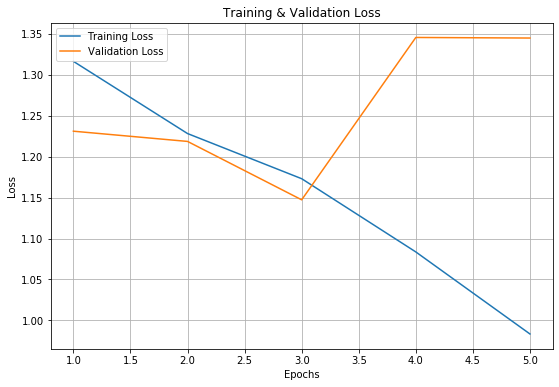

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(History_Conv.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, History_Conv.history['loss'])
plt.plot(epochs, History_Conv.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

### (2) Accuracy

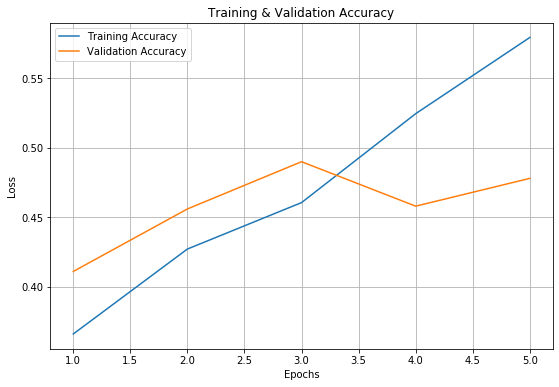

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(History_Conv.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, History_Conv.history['accuracy'])
plt.plot(epochs, History_Conv.history['val_accuracy'])

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

## 6) 결과 산출

In [ ]:
model_Conv.load_weights(checkpoint_path)

### (1) Loss & Accuracy

In [ ]:
loss, accuracy = model_Conv.evaluate(test_x, test_y,
                                batch_size = batch_size)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

250/250 [==============================] - 19s 76ms/step - loss: 1.0158 - accuracy: 0.5840
Loss = 1.01582
Accuracy = 0.58400


### (2) Confusion Matrix

In [ ]:
with tf.device("cpu:0"):
    y_hat = model_Conv.predict(test_x)

In [ ]:
y_hat = np.argmax(y_hat, axis=1)

In [ ]:
test_y = np.argmax(test_y, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(test_y, y_hat)
conf_mat

## 7) 모델 Save

In [ ]:
save_dir = 'Models'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

final_model_name = '/' + 'rgb' + '_' + 'Conv2D_GRU' + '.h5'

model.save(save_dir + final_model_name)

# IV. MobileNet + GRU Modeling

## 1) 모델 생성

In [ ]:
MODELNAME='rgb_basic_mobilenet_gru_batchNomal'

CLASSES = 4
SIZE = (128, 128)
CHANNELS = 3 # RGB scale
NBFRAME = 64 
BS = 16

SPLIT_RATIO = (.2, .1)

In [ ]:
epochs = 5
batch_size = 2

In [ ]:
SIZE + (CHANNELS,)

(128, 128, 3)

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras import Sequential
from keras.layers import TimeDistributed, GRU, Dense, Dropout, GlobalAveragePooling2D

def build_mobilenet(shape=SIZE + (CHANNELS,)):
    model = MobileNet(include_top=False,
                      input_shape=shape,
                      weights='imagenet')

    # Keep 9 layers to train
    trainable = 9
    for layer in model.layers[:-trainable]:
        layer.trainable = False
    for layer in model.layers[-trainable:]:
        layer.trainable = True
    
    output = GlobalAveragePooling2D()

    return Sequential([model, output])

In [ ]:
from keras import models, layers

def action_model(shape=(NBFRAME,) + SIZE + (CHANNELS,), nbout=CLASSES):
    # Create our convnet with (128, 128, 1) input shape
    mobilenet = build_mobilenet(shape[1:])
    
    # then create our final model
    model = Sequential()

    # add the convnet with (64, 128, 128, 3) shape
    model.add(TimeDistributed(mobilenet, input_shape=shape))
    
    # here, you can also µuse GRU or LSTM
    model.add(GRU(64))
    
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))

    return model

In [ ]:
from keras.applications.mobilenet import MobileNet
model = MobileNet(include_top=False,
    input_shape=(128,128,3),
                  weights='imagenet')
model.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32) 

In [ ]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (64, 128, 128, 3)

model = action_model(INSHAPE, CLASSES)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 64, 1024)          3228864   
_________________________________________________________________
gru (GRU)                    (None, 64)                209280    
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              66560     
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

## 2) Checkpoint 설정

In [ ]:
import tensorflow as tf

checkpoint_path = "training_Mobilenet_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

## 3) 모델 Compile

In [ ]:
from keras import optimizers

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr=0.0001), # defalut : 0.001
              metrics = ['accuracy'])

## 4) 모델 학습

In [ ]:
%%time

History = model.fit(train_x, train_y,
                   epochs = epochs,
                   batch_size = batch_size,
                   validation_data = (val_x, val_y),
                   callbacks=[cp_callback])

Epoch 1/5
1750/1750 [==============================] - 315s 172ms/step - loss: 1.5618 - accuracy: 0.3143 - val_loss: 1.8066 - val_accuracy: 0.4300

Epoch 00001: saving model to training_Mobilenet_3/cp.ckpt
Epoch 2/5
1750/1750 [==============================] - 290s 166ms/step - loss: 1.2960 - accuracy: 0.4050 - val_loss: 1.7490 - val_accuracy: 0.4490

Epoch 00002: saving model to training_Mobilenet_3/cp.ckpt
Epoch 3/5
1750/1750 [==============================] - 290s 166ms/step - loss: 1.2537 - accuracy: 0.4602 - val_loss: 1.6741 - val_accuracy: 0.4440

Epoch 00003: saving model to training_Mobilenet_3/cp.ckpt
Epoch 4/5
1750/1750 [==============================] - 290s 165ms/step - loss: 1.2213 - accuracy: 0.4564 - val_loss: 1.5199 - val_accuracy: 0.4780

Epoch 00004: saving model to training_Mobilenet_3/cp.ckpt
Epoch 5/5
1750/1750 [==============================] - 289s 165ms/step - loss: 1.2536 - accuracy: 0.4350 - val_loss: 1.5704 - val_accuracy: 0.4490

Epoch 00005: saving model to

## 5) 결과 시각화

### (1) Loss

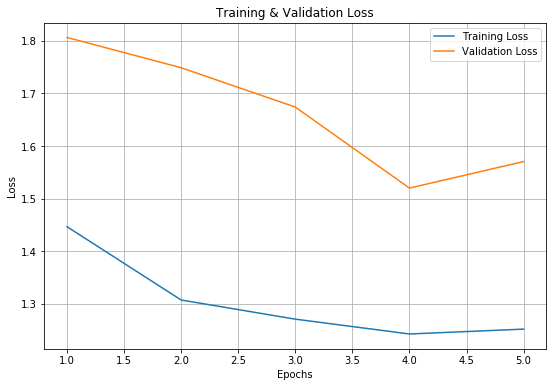

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(History.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, History.history['loss'])
plt.plot(epochs, History.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

### (2) Accuracy

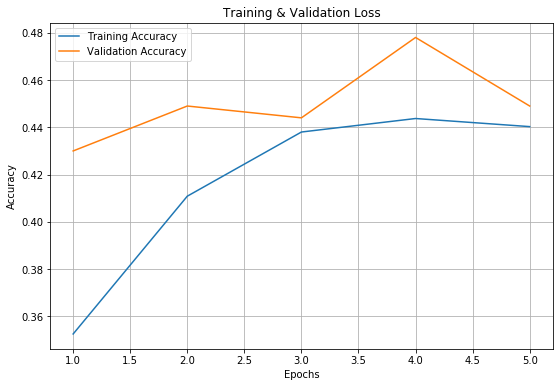

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(History.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, History.history['accuracy'])
plt.plot(epochs, History.history['val_accuracy'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

## 6) 결과 산출

In [ ]:
model.load_weights(checkpoint_path)

### (1) Loss & Accuracy

In [ ]:
loss, accuracy = model.evaluate(test_x, test_y,
                                batch_size = batch_size)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

250/250 [==============================] - 29s 71ms/step - loss: 2.1339 - accuracy: 0.3782
Loss = 1.54999
Accuracy = 0.48800


### (2) Confusion Matrix

In [ ]:
with tf.device("cpu:0"):
    y_hat = model.predict(test_x)

In [ ]:
y_hat = np.argmax(y_hat, axis=1)

In [ ]:
test_y = np.argmax(test_y, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(test_y, y_hat)
conf_mat

array([[103,  15,  12,  20],
       [ 20,  51,  29,   0],
       [ 26,  44,  55,  25],
       [ 35,  25,   5,  35]])

## 7) 모델 Save

### (1) 모델 Save

In [ ]:
save_dir = 'Models'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

final_model_name = '/' + 'rgb' + '_' + 'MobileNet_GRU_BatchNormal' + '.h5'

model.save(save_dir + final_model_name)

### (2) 모델 Save 확인

In [ ]:
from keras.models import load_model

rgb_cnn_lstm = load_model(save_dir + final_model_name)

loss, accuracy = rgb_cnn_lstm.evaluate(test_x, test_y,
                                batch_size = batch_size)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

500/500 [==============================] - 20s 38ms/step - loss: 6.4818 - accuracy: 0.3300
Loss = 6.48184
Accuracy = 0.33000


# V. VGG16 + LSTM Modeling

## 1) 모델 생성

In [ ]:
IMG_FRAMES = 64
IMG_WIDTH = 128
IMG_HEIGHT = 128
CHANNEL_RGB = 3

CLASSES = 4

### (1) VGG16

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNEL_RGB))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

### (2) Fine Tuning

In [ ]:
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
        
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

### (3) 모델 생성

In [ ]:
from keras import models, layers
from keras import Sequential
from keras.layers import TimeDistributed, LSTM, Dense, Dropout, Flatten, GlobalAveragePooling2D

model_vgg_3 = models.Sequential()
model_vgg_3.add(TimeDistributed(conv_base, input_shape = (IMG_FRAMES, IMG_HEIGHT, IMG_WIDTH, CHANNEL_RGB)))

model_vgg_3.add(TimeDistributed(GlobalAveragePooling2D()))

model_vgg_3.add(LSTM(128, activation='relu', return_sequences=False))

model_vgg_3.add(Dense(1024, activation='relu'))
model_vgg_3.add(Dropout(0.5))
model_vgg_3.add(Dense(512, activation='relu'))
model_vgg_3.add(Dropout(0.5))
model_vgg_3.add(Dense(128, activation='relu'))
model_vgg_3.add(Dropout(0.5))
model_vgg_3.add(Dense(64, activation='relu'))
model_vgg_3.add(Dense(CLASSES, activation='softmax'))

model_vgg_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 64, 4, 4, 512)     14714688  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 64, 512)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               328192    
_________________________________________________________________
dense (Dense)                (None, 1024)              132096    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

## 2) Checkpoint 설정

In [ ]:
import tensorflow as tf

checkpoint_path = "training_VGG16_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

## 3) 모델 Compile

In [ ]:
from keras import optimizers

model_vgg_3.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr=0.0001), # defalut : 0.001
              metrics = ['accuracy'])

In [ ]:
epochs = 10
batch_size = 2

## 4) 모델 학습

In [ ]:
%%time

History_vgg_3 = model_vgg_3.fit(train_x, train_y,
                   epochs = epochs,
                   batch_size = batch_size,
                   validation_data = (val_x, val_y),
                   callbacks=[cp_callback])

## 5) 결과 시각화

### (1) Loss

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(History_vgg_3.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, History_vgg_3.history['loss'])
plt.plot(epochs, History_vgg_3.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

### (2) Accuracy

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(History_vgg_BatchNor.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, History_vgg_3.history['accuracy'])
plt.plot(epochs, History_vgg_3.history['val_accuracy'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

## 6) 결과 산출

In [ ]:
model_vgg_3.load_weights(checkpoint_path)

### (1) Loss & Accuracy

In [ ]:
loss, accuracy = model_vgg_3.evaluate(test_x, test_y,
                                batch_size = batch_size)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

250/250 [==============================] - 68s 198ms/step - loss: 3.1267 - accuracy: 0.6027
Loss = 2.58611
Accuracy = 0.59200


### (2) Confusion Matrix

In [ ]:
with tf.device("cpu:0"):
    y_hat = model_vgg_3.predict(test_x)

In [ ]:
test_y

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [ ]:
y_hat

array([[1.22490805e-04, 5.74607821e-03, 9.87581015e-01, 6.55043870e-03],
       [3.36392375e-04, 1.09176096e-02, 9.75752771e-01, 1.29932342e-02],
       [1.20314086e-04, 5.59605891e-03, 9.87758934e-01, 6.52470347e-03],
       ...,
       [7.41437495e-01, 1.83156622e-03, 9.26308613e-03, 2.47467965e-01],
       [4.22174968e-02, 2.83146068e-03, 3.26394700e-02, 9.22311544e-01],
       [7.44435072e-01, 1.81130425e-03, 9.14488174e-03, 2.44608730e-01]],
      dtype=float32)

In [ ]:
y_hat = np.argmax(y_hat, axis=1)

In [ ]:
test_y = np.argmax(test_y, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(test_y, y_hat)
conf_mat

array([[60,  0, 35, 55],
       [10, 70, 20,  0],
       [ 0, 15, 95, 40],
       [ 4,  0, 25, 71]])

## 7) 모델 Save

In [ ]:
save_dir = 'Models'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

final_model_name = '/' + 'rgb' + '_' + 'VGG16_LSTM3' + '.h5'

model_vgg_3.save(save_dir + final_model_name)